In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.interpolate
import numpy as np
import scipy.stats as sts

n0 = 0.16
pi = np.pi
MeV_to_km = 1.323e-6

In [2]:
EOS_small = pd.read_table('../data/EOSCEFTVE1.dat', header=None).to_numpy()

We are going to extend this table through the speed of sound. We are using the speed of sound because of it's definition:

$$ c_s^2 = \frac{\partial p(\epsilon)}{\partial \epsilon} $$

The mechanics will work like Ingo et. al. where we step the baryon density, $n$, by a small $\Delta n$,

$$ n_{i+1} = n_i + \Delta n $$

where $i$ is the index of our data array. Then we use the speed of sound, $c_s$, and a thermodynamic identity to get the energy density and pressure.

$$
\begin{align}
    \epsilon_{i+1} &= \epsilon_i + \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)\\
    p_{i+1} &= p_i + c_s^2(n_i) \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)
\end{align}
$$
    
We will be defining our speed of sound curve in this notebook by specifying its value at a number of points and just connecting the two with linear segments. The speed of sound (in units where c=1) must be between 0 and 1 to keep causality.

To begin, let's get the speed of sound in the range we already have (n < 2n0).

In [3]:
n = EOS_small[:,0]/n0 # put in units of n0
p = MeV_to_km*EOS_small[:,1] # change to c=G=1
e = MeV_to_km*EOS_small[:,2] # change to c=G=1

# derivative of pressure wrt energy
dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)

#definition of speed of sound
c_s_2n0 = np.sqrt(1/dp_de(p[-1]))
print(c_s_2n0)

0.3654078562510514


In [4]:
def sample_cs(num_points, max_n, n_start, cs_start):
    
    n = np.linspace(n_start, max_n, num_points+1, endpoint=True)
    c = cs_start*np.ones(1)
    sample_cs = sts.uniform.rvs(size=num_points)
    cs = np.append(c, sample_cs)
    
    return n, cs

In [5]:
num_points = 4
n_start = 2
max_n = 10

ns, cs = sample_cs(num_points, max_n, n_start, c_s_2n0)

print(ns, cs)

cs_func = scipy.interpolate.interp1d(ns[0:2], cs[0:2])

[ 2.  4.  6.  8. 10.] [0.36540786 0.28628102 0.25784101 0.66965001 0.43157952]


In [6]:
size = 400
true_size = num_points*size + 1

# initialize array
EOS_ex = np.zeros((true_size, 3))
# set starting values at n = 2n0
EOS_ex[0,0] = n_start
EOS_ex[0,1] = p[-1]
EOS_ex[0,2] = e[-1]

for i in range(num_points):
    
    n_step = (ns[i+1] - ns[i])/size
    cs_func = scipy.interpolate.interp1d(ns[i:i+2], cs[i:i+2])
    EOS_ex[i*size,0] = ns[i]
    
    for j in range(size):
        
        k = size*i+j
        
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # e_i+1
        EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # p_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*(cs_func(EOS_ex[k,0])**2)*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])

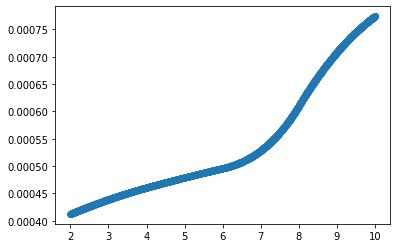

In [7]:
plt.plot(EOS_ex[:,0], EOS_ex[:,2], 'o')

In [8]:
def stitch_EOS(small_EOS, EOS_ex):
    
    # get relevant sizes
    size_smol = small_EOS.shape[0] -1 # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]
    
    # initialize array
    tot_EOS = np.zeros((size_smol+size_ex, small_EOS.shape[1]))
    
    tot_EOS[:size_smol,:] = small_EOS[:size_smol,:]
    tot_EOS[size_smol:,0] = EOS_ex[:,0]*n0
    tot_EOS[size_smol:,1] = EOS_ex[:,1]/MeV_to_km
    tot_EOS[size_smol:,2] = EOS_ex[:,2]/MeV_to_km
    
    return tot_EOS

In [9]:
tot_EOS = stitch_EOS(EOS_small, EOS_ex)

np.savetxt('../data/EOS_test.dat', tot_EOS)

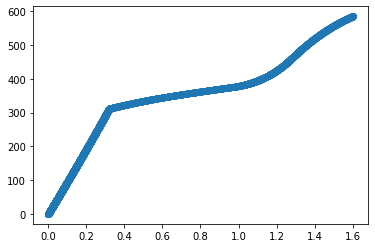

In [10]:
plt.plot(tot_EOS[:,0], tot_EOS[:,2], 'o')

[0.]


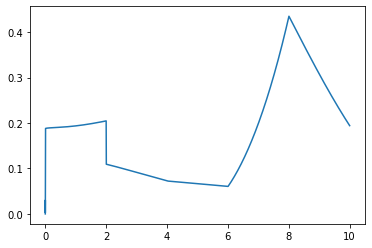

In [11]:
p_tot = tot_EOS[:,2]
leng = p_tot.shape[0]
del_p = np.zeros(leng)

for i in range(leng-1):
    del_p[i+1] = p_tot[i+1] - p_tot[i]
    
plt.plot(tot_EOS[:,0]/n0, del_p)
print(del_p[del_p==0])

In [12]:
import real_TOVsolver

max_pressure = 350 #MeV/fm3
MRL_test = real_TOVsolver.solve(tot_EOS, max_pressure)
np.savetxt('../data/MRL_test.dat', MRL_test)

C:\Users\brend\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 1.0, 'Tidal Polarizability as a Function of Mass')

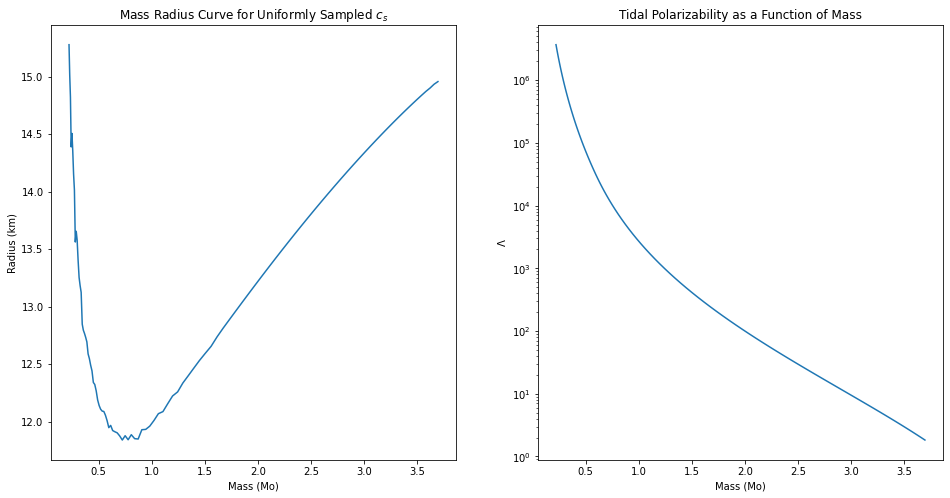

In [13]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(MRL_test[:,0], MRL_test[:,1])
ax[0].set_xlabel('Mass (Mo)')
ax[0].set_ylabel('Radius (km)')
ax[0].set_title('Mass Radius Curve for Uniformly Sampled $c_s$')

ax[1].plot(MRL_test[:,0], MRL_test[:,2])
ax[1].set_xlabel('Mass (Mo)')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].set_title('Tidal Polarizability as a Function of Mass')